# Imports

In [131]:
import catboost as cb
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import geopandas as gpd

from shapely.geometry import Polygon, MultiPolygon
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


# Configs

In [132]:
INPUT_PATH = 'datasets/'
ARIMA_PATH = 'statics/arima_predict.parquet'
OUTPUT_PATH = 'results/xgb_predictions.parquet'

RIDGE_TEST_PATH = 'results/ridge_test_predictions.parquet'
RIDGE_TRAIN_PATH = 'results/ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [#'ARIMA_predicts',
                # 'borough',
                
                # 'Previous_week_trip_dist',
                # 'Previous_2week_trip_dist',
                # 'Previous_day_trip_dist',

                # 'Previous_week_passenger_count',
                # 'Previous_2week_passenger_count',
                # 'Previous_day_passenger_count',

                # 'Previous_week_fare_amount',
                # 'Previous_day_fare_amount',
                # 'Previous_2week_fare_amount',
                'Ridge_predict',
                'X',
                'Y',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                # 'Previous_2day_demand',
                # 'Previous_3day_demand',
                # 'Previous_4day_demand',
                # 'Previous_5day_demand',
                # 'Previous_6day_demand',
                # 'Previous_8day_demand',
                # 'Previous_9day_demand',
                # 'Previous_10day_demand',
                # 'Previous_11day_demand',
                # 'Previous_12day_demand',
                # 'Previous_13day_demand',

                # 'Previous_week_extra',
                # 'Previous_2week_extra',
                # 'Previous_day_extra',
                
                # 'Previous_2week_RatecodeID',
                # 'Previous_week_RatecodeID',
                # 'Previous_day_RatecodeID',

                # 'Previous_week_congestion_surcharge',
                # 'Previous_2week_congestion_surcharge',
                # 'Previous_day_congestion_surcharge',

                # 'Day_of_month', 
                # 'Day_of_week',
                # 'Location'
                ]

TEST_START_DATE = '2023-04-01'

AUTO_TUNE = True

# Data preparation


## Load Data

In [133]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [134]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [135]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


In [136]:
ridge_train_df = pd.read_parquet(RIDGE_TRAIN_PATH)
ridge_test_df = pd.read_parquet(RIDGE_TEST_PATH)
ridge_df = pd.concat([ridge_train_df, ridge_test_df], axis = 0)

In [137]:
print(f'ridge dataframe shape : {ridge_df.shape}')
ridge_df.head()

ridge dataframe shape : (27772, 3)


,Location,Date,Predicted_demand
0,1,2023-01-15,20.656202
1,1,2023-01-16,23.970770
2,1,2023-01-17,16.012022
3,1,2023-01-18,13.602784
4,1,2023-01-19,13.699893


In [138]:
regions_df = gpd.read_file('taxi_zones/taxi_zones.shp')
regions_df = regions_df.rename(columns = {'LocationID' : 'Location'})

In [139]:
def extract_coordinates(geom):
    x_coords = []
    y_coords = []
    
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = geom.geoms
        
    for polygon in polygons:
        coords = polygon.exterior.coords
        x_coords.extend([point[0] for point in coords])
        y_coords.extend([point[1] for point in coords])
    
    return x_coords, y_coords

In [140]:
regions_df[['X', 'Y']] = regions_df['geometry'].apply(lambda geom: pd.Series(extract_coordinates(geom)))
regions_df.loc[56, 'Location'] = 57

In [141]:
for i in range(len(regions_df)):
    regions_df['Y'][i] = np.mean(regions_df['Y'][i])
    regions_df['X'][i] = np.mean(regions_df['X'][i])
regions_df = regions_df[['Location', 'X', 'Y']]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Labeling

In [142]:
def labeling(dataset, zones):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .merge(zones, how='left', on=['Location'])
        .fillna(value=0)
    )
    return labels_df


In [143]:
labeled_df = labeling(rides_df, regions_df)

In [144]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 5)


,Location,Date,Demand,X,Y
0,1,2023-01-01,40.0,935920.967412,190798.948561
1,1,2023-01-02,31.0,935920.967412,190798.948561
2,1,2023-01-03,27.0,935920.967412,190798.948561
3,1,2023-01-04,7.0,935920.967412,190798.948561
4,1,2023-01-05,15.0,935920.967412,190798.948561


In [145]:
labeled_df.to_parquet('labels.parquet')

## Add Feature

In [146]:
def feature_engineering(dataset, ridge_df):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['Location'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['Location'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['Location'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['Location'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['Location'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['Location'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day

    dataset = (
        dataset
        .merge(ridge_df, how='left', on=['Location', 'Date'])
        .rename(columns = {'Predicted_demand' : 'Ridge_predict'})
        )



    return dataset

In [147]:
features_df = feature_engineering(labeled_df, ridge_df)
features_df.dropna(inplace = True)

In [148]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 22)


,Location,Date,Demand,X,Y,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,...,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,Ridge_predict
14,1,2023-01-15,19.0,935920.967412,190798.948561,7.0,21.0,8.0,9.0,4.0,...,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15,20.656202
15,1,2023-01-16,21.0,935920.967412,190798.948561,19.0,7.0,21.0,8.0,9.0,...,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16,23.970770
16,1,2023-01-17,18.0,935920.967412,190798.948561,21.0,19.0,7.0,21.0,8.0,...,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17,16.012022
17,1,2023-01-18,10.0,935920.967412,190798.948561,18.0,21.0,19.0,7.0,21.0,...,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18,13.602784
18,1,2023-01-19,9.0,935920.967412,190798.948561,10.0,18.0,21.0,19.0,7.0,...,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19,13.699893


In [149]:
pca = PCA()
pca.fit(features_df[FEATURE_LIST])


cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum, len(FEATURE_LIST), pca.feature_names_in_

(array([0.93989462, 0.999711  , 0.99999665, 0.99999929, 0.99999991,
        1.        ]),
 6,
 array(['Ridge_predict', 'X', 'Y', 'Previous_2week_demand',
        'Previous_week_demand', 'Previous_day_demand'], dtype=object))

## Split Train and Test Data

In [150]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [151]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)
'''pca = PCA(n_components = 5)
xtrain = pca.fit_transform(train_df[FEATURE_LIST])

pca = PCA(n_components = 5)
xtest = pca.fit_transform(test_df[FEATURE_LIST])

pca.fit(features_df[FEATURE_LIST])'''

'pca = PCA(n_components = 5)\nxtrain = pca.fit_transform(train_df[FEATURE_LIST])\n\npca = PCA(n_components = 5)\nxtest = pca.fit_transform(test_df[FEATURE_LIST])\n\npca.fit(features_df[FEATURE_LIST])'

In [152]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 22)


,Location,Date,Demand,X,Y,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,...,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,Ridge_predict
14,1,2023-01-15,19.0,935920.967412,190798.948561,7.0,21.0,8.0,9.0,4.0,...,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15,20.656202
15,1,2023-01-16,21.0,935920.967412,190798.948561,19.0,7.0,21.0,8.0,9.0,...,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16,23.970770
16,1,2023-01-17,18.0,935920.967412,190798.948561,21.0,19.0,7.0,21.0,8.0,...,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17,16.012022
17,1,2023-01-18,10.0,935920.967412,190798.948561,18.0,21.0,19.0,7.0,21.0,...,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18,13.602784
18,1,2023-01-19,9.0,935920.967412,190798.948561,10.0,18.0,21.0,19.0,7.0,...,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19,13.699893


In [153]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 22)


,Location,Date,Demand,X,Y,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,...,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,Ridge_predict
90,1,2023-04-01,13.0,935920.967412,190798.948561,13.0,13.0,7.0,14.0,3.0,...,9.0,21.0,9.0,6.0,14.0,33.0,25.0,5,1,18.305568
91,1,2023-04-02,17.0,935920.967412,190798.948561,13.0,13.0,13.0,7.0,14.0,...,15.0,9.0,21.0,9.0,6.0,14.0,33.0,6,2,19.965612
92,1,2023-04-03,9.0,935920.967412,190798.948561,17.0,13.0,13.0,13.0,7.0,...,14.0,15.0,9.0,21.0,9.0,6.0,14.0,0,3,10.428255
93,1,2023-04-04,12.0,935920.967412,190798.948561,9.0,17.0,13.0,13.0,13.0,...,3.0,14.0,15.0,9.0,21.0,9.0,6.0,1,4,10.465925
94,1,2023-04-05,18.0,935920.967412,190798.948561,12.0,9.0,17.0,13.0,13.0,...,14.0,3.0,14.0,15.0,9.0,21.0,9.0,2,5,9.996610


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [154]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [155]:
if AUTO_TUNE:
    params_test = {'learning_rate':[0.2, 0.15, 0.1, 0.05], 
                'subsample':[0.6, 0.7, 0.8, 0.9, 1], 
                'colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1], 
                'max_depth':[ 7, 8, 9, 10], 
                'min_child_weight':[1, 10, 20, 30, 40, 50],
                }
    params = {"objective": "reg:squarederror"}

    best_params, best_score = grid_search(
        model = xgb.XGBRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 3
        )
    
    print(best_params, best_score)
else:
    best_params = {
        'colsample_bytree': 0.7, 
        'learning_rate': 0.05, 
        'max_depth': 7, 
        'min_child_weight': 20, 
        'subsample': 0.8
        }

### Prediction

In [156]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    '''model.fit(train_data[feature_list], train_data['Demand'], 
            eval_set=[(test_data[feature_list], test_data['Demand'])], 
            early_stopping_rounds=100)
    print(np.min(model.evals_result()['validation_0']['rmse']))'''
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [157]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [158]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [159]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

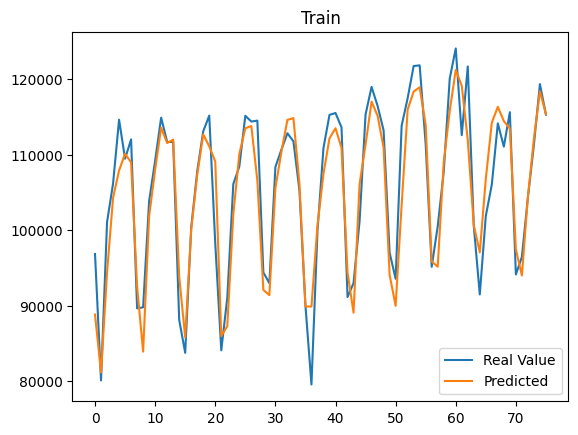

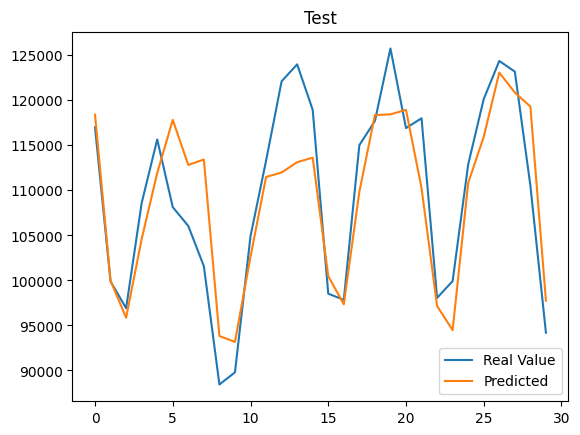

In [160]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [161]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [162]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)


In [163]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 24.778036012545126
MSE : 6179.031345774198
MAPE : 722782847757271.5
XGB test scores:
MAE : 30.419010968093048
MSE : 8684.054946703156
MAPE : 714341291175438.1


### Feature Importance and SHAPE

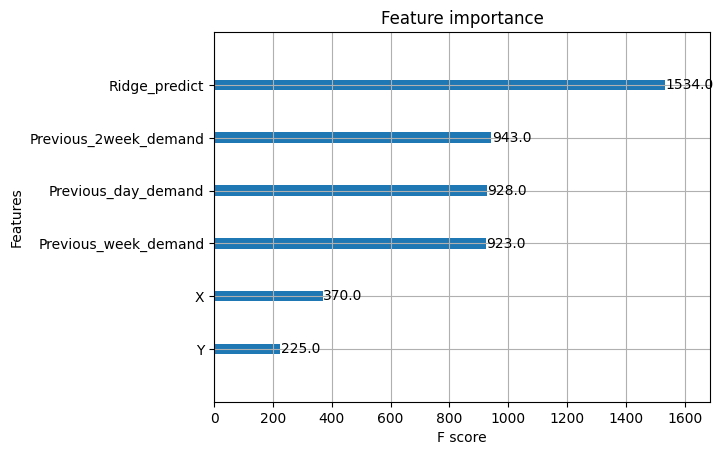

In [164]:
xgb.plot_importance(model)
plt.show()

In [165]:
'''dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[FEATURE_LIST])'''

"dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)\n\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(dtrain_reg)\nshap.summary_plot(shap_values, train_df[FEATURE_LIST])"

# File Saving

In [166]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [167]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [168]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [169]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,18.603355
1,1,2023-04-02,17.931076
2,1,2023-04-03,10.210643
3,1,2023-04-04,9.369025
4,1,2023-04-05,9.995961


In [170]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)